# P10 Détecter les faux billets - Prédiction

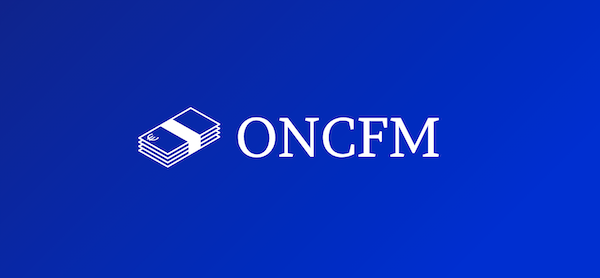

# **Introduction**

**Auteur** = Lauren GUIOT

**Date** = 19/06/23

L'ONCEFM a besoin d'un algorithme qui permet de détecter les faux billets à partir des dimensions géométriques des billets.

Ce notebook permettra de prédire l'authenticité des billets .

In [1]:
import pandas as pd
import numpy as np
import pickle    # récuperer sauvegarde l'apprentissage

# Preprocession
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, PowerTransformer

#Modèles
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression

In [2]:
# Définir les colonnes
target = ["is_genuine"]               # la target
drop_col =["id", "is_genuine"]                      # supprimer des variables
features = ["diagonal", "height_left", "height_right", "margin_up","length"] # Variables sans preprocessing
numNaN = ["margin_low"]               # Variables numériques avec NaN

# FONCTION de remplissage des NaN
def suppNaN (X):    # FONCTIONNE SUR LA PIPELINE DIRECT avec Sklearn
    if X.isna().sum().sum()>0: #condition pour si il y a des NaN
        scale = PowerTransformer(method="yeo-johnson")
        X_Scaled= pd.DataFrame(scale.fit_transform(X), columns=X.columns) # Standardisation des variables
        supp = target+ numNaN 
        parameters= list(set(X_Scaled.columns) - set(supp))  # Variables permettant de prédire les valeurs manquantes (sans is_genuine et Margin_low)
        model = LinearRegression()
        nonulls= X_Scaled.dropna() # Tables sans valeur manquantes
        for i in numNaN: # Boucle pour appliquer la régression linéaire sur toutes les variables avec valeurs manquantes
            null = X_Scaled.loc[X_Scaled[i].isnull()] # Tables avec valeur manquantes
            model.fit(X = nonulls[parameters], y= nonulls[i])  # Modèle apprentissage sur table sans NaN
            X_Scaled.loc[X_Scaled[i].isnull(), i] = model.predict(null[parameters]) # Prediction sur la table avec NaN et les remplacer
        X_prep = pd.DataFrame(scale.inverse_transform(np.array(X_Scaled)), columns= X_Scaled.columns) # revenir sur les données d'origines

    else: # si pas de valeurs manquantes
        df1= pd.DataFrame(X)
        X_prep= df1.copy()

    for i in drop_col: # Rajout d'une boucle pour supprimer les colonnes non utiles
        if X_prep.columns.all() == i:
            X_prep = X_prep.drop([i], axis=1)
        else:
            X_prep
    return(X_prep)

preprocessing = FunctionTransformer(suppNaN)


### Données d'apprentissage
filname= 'finalized_model.sav'  # régression Logistique
pipeline_final = pickle.load(open(filname, 'rb')
                            )
filname2= 'finalized_modelkm.sav'  # Kmeans
km = pickle.load(open(filname2, 'rb'))

filname3= 'encoder.sav'    # Encodage
Target_encoder = pickle.load(open(filname3, 'rb'))

#Fonction de Prédiction
def predictionML(table): # PrédictionML
    table= table.reset_index(drop=True)
    predict= pipeline_final.predict(table) # prédiction sur nouveau jeu de donnée
    decod= Target_encoder.inverse_transform(predict)  # décodage
    proba= pd.DataFrame(pipeline_final.predict_proba(table)) # Calcul de la proba d'appartenir au groupe 1 ou 0
    table=table.assign(is_genuine= decod)
    table= table.assign(probaFaux= proba[0])
    table= table.assign(probaVrai= proba[1])
    return table

def PredY(table):     #Kmean
    news = pd.DataFrame(preprocessing.transform(table)) # Preprocessing pour supprimer les potentiels NaN
    news= news.reset_index(drop=True)
    predict= km.predict(news) # prédiction sur nouveau jeu de donnée avec KM
    Y_pred=Target_encoder.inverse_transform(predict)  # décodage
    news= nouveau.assign(is_genuine= Y_pred) # Rajout de la prédiction dans la table
    return news

###   <a class="anchor" id="1.1"></a>     importer le nouveau jeu de données

In [3]:
nouveau= pd.read_csv("billets_production.csv", sep="," )
nouveau.head(2)

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2


###   <a class="anchor" id="2.1"></a>     Prédiction sur nouvelles données


####   <a class="anchor" id="V.2.a"></a>     Appliquer sur Kmeans

In [4]:
PredY(nouveau)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


####   <a class="anchor" id="2.1"></a>     Appliquer le modèle ML

In [5]:
pipeline_final.predict(nouveau)

array([0, 0, 0, 1, 1])

In [6]:
predictionML(nouveau)

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine,probaFaux,probaVrai
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,0.999558,0.000442
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,0.999947,0.000053
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,0.999911,0.000089
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,0.019326,0.980674
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,0.000063,0.999937
